In [8]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [9]:
# import the dataset 
# load in the Excel file and turn into dataframme 
file_path = "Shloshim.xlsx"
df = pd.read_excel(file_path, sheet_name=0)

# rename the columns for easier access
df.rename(columns={
    'Date': 'Date',
    'NVDA UW Equity - Last Price': 'NVDA',
    'AMD UW Equity - Last Price': 'AMD'
}, inplace=True)

# convert the date column to datetime for time series analysis 
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)  

In [10]:
# cleaning the dataset 

# # first we check for the missing values 
# # Check for missing values in each column
# missing_values = df.isnull().sum()
# missing_values

# # since there is only one missing row, then interpolate
# df.interpolate(method='linear', inplace=True)

# # confirming that missing values are handled
# missing_2 = df.isnull().sum()
# missing_2

num_cols = ["NVDA", "AMD"] # add more if needed
df[num_cols] = df[num_cols].interpolate() # linear is default
df.dropna(subset=num_cols, inplace=True) # prune any residual NaNs   

# create a rebased series
df["NVDA_rebased"] = df["NVDA"] / df["NVDA"].iloc[0]
df["AMD_rebased"]  = df["AMD"]  / df["AMD"].iloc[0]

# look at the result
display(df.head())

,NVDA,AMD,NVDA_rebased,AMD_rebased
Date,,,,
2025-03-13,115.58,98.11,1.000000,1.000000
2025-03-12,115.74,100.79,1.001384,1.027316
2025-03-11,108.76,96.76,0.940993,0.986240
2025-03-10,106.98,96.63,0.925593,0.984915
2025-03-07,112.69,100.31,0.974996,1.022424


In [11]:
# # normalise prices to compare relative change in values 
# # min-max normalisation based on first row
# df['NVDA_norm'] = df['NVDA'] / df['NVDA'].iloc[0]
# df['AMD_norm'] = df['AMD'] / df['AMD'].iloc[0]

# # Kalman Filter for pairs trading assumes the spread is stationary 
# # calculate the spread then apply the ADF test.
# from statsmodels.tsa.stattools import adfuller

# spread = df['NVDA_norm'] - df['AMD_norm']  

# adf_result = adfuller(spread)
# print("ADF Statistic:", adf_result[0])
# print("p-value:", adf_result[1])

In [12]:
# # the p value for the last normalisation was > 0.05 so we reject null hypothesis 
# # we try log prices instead of normal ones 
# df['log_NVDA'] = np.log(df['NVDA'])
# df['log_AMD'] = np.log(df['AMD'])
# spread2 = df['log_NVDA'] - df['log_AMD']

# adf_result2 = adfuller(spread2)
# print("ADF Statistic:", adf_result2[0])
# print("p-value:", adf_result2[1])

# # p values < 0.05 so we accept null hypothesis 

In [13]:
# computing the intitial hedge ratio

# define the two price series
X = df['AMD']
Y = df['NVDA']
# adding constant to X for the intercept term
X_const = sm.add_constant(X)

# fit the Ordinary Least Square model
ols_model = sm.OLS(Y, X_const).fit()

alpha, beta = ols_model.params        # α = intercept, β = hedge ratio
print(f"Intercept α  : {alpha: .6f}")
print(f"Hedge ratio β: {beta: .6f}")

# Compute static spread using BOTH α and β
df["spread_static"] = Y - (alpha + beta * X)

# Optional: quick stationarity check
from statsmodels.tsa.stattools import adfuller
adf_stat, p_val, *_ = adfuller(df["spread_static"].dropna())
print(f"ADF stat = {adf_stat: .3f},  p‑value = {p_val: .4f}")

Intercept α  : -49.389033
Hedge ratio β:  0.872654
ADF stat = -2.661,  p‑value =  0.0811


In [14]:
import numpy as np
from statsmodels.tsa.stattools import adfuller

# -------- 7 a.  Run a 1‑state Kalman filter for βₜ  --------
def kalman_beta(y, x, q= 0.0001, r= 1.0, beta0=0.0, P0=1.0):
    """Return series of time‑varying hedge ratios βₜ."""
    n = len(x)
    beta = np.empty(n)
    P    = np.empty(n)

    beta[0], P[0] = beta0, P0

    for t in range(1, n):
        # Prediction
        P_pred = P[t-1] + q

        # Update
        K_t = P_pred * x[t] / (x[t]**2 * P_pred + r)
        beta[t] = beta[t-1] + K_t * (y[t] - beta[t-1] * x[t])
        P[t] = (1 - K_t * x[t]) * P_pred

    return beta

y = df["NVDA"].values
x = df["AMD"].values

beta_dyn = kalman_beta(y, x)

# -------- 7 b.  Dynamic spread and stationarity check --------
df["spread_dyn"] = df["NVDA"] - beta_dyn * df["AMD"]

adf_stat, p_val, *_ = adfuller(df["spread_dyn"])
print(f"ADF stat = {adf_stat:.3f},  p‑value = {p_val:.4f}")


ADF stat = -10.563,  p‑value = 0.0000


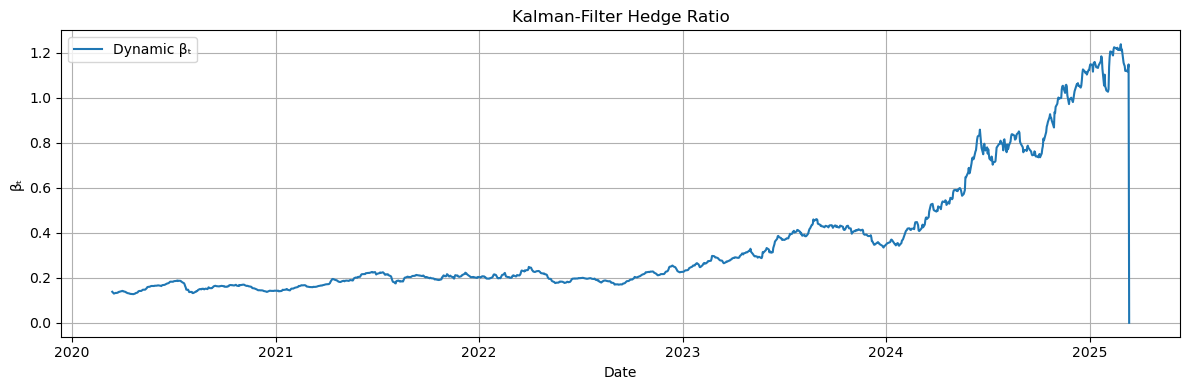

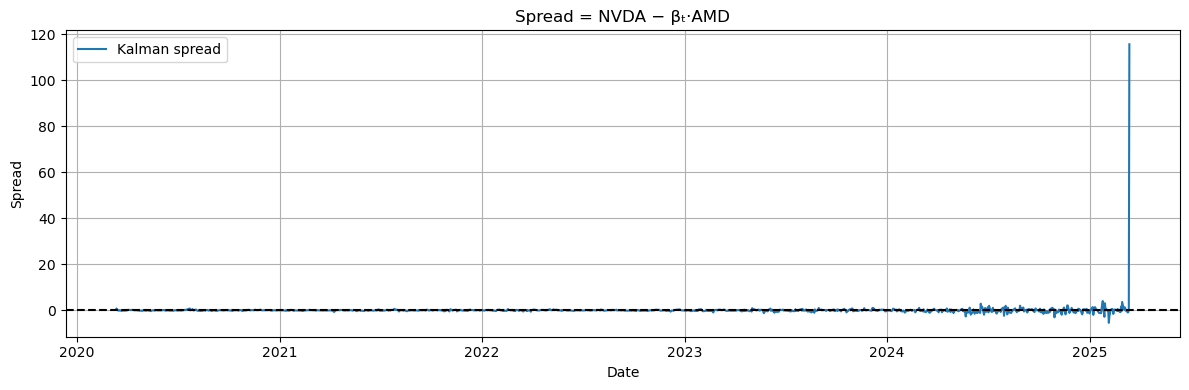

In [17]:
import matplotlib.pyplot as plt

# ---- 8 a. Hedge ratio ----
plt.figure(figsize=(12, 4))
plt.plot(df.index, beta_dyn, label="Dynamic βₜ")
plt.title("Kalman‑Filter Hedge Ratio")
plt.xlabel("Date");  plt.ylabel("βₜ")
plt.grid();  plt.legend();  plt.tight_layout()
plt.show()

# ---- 8 b. Spread ----
plt.figure(figsize=(12, 4))
plt.plot(df.index, df["spread_dyn"], label="Kalman spread")
plt.axhline(0, color="k", ls="--")
plt.title("Spread = NVDA − βₜ·AMD")
plt.xlabel("Date");  plt.ylabel("Spread")
plt.grid();  plt.legend();  plt.tight_layout()
plt.show()


In [19]:
# -------- 9 a.  Z‑score --------
mean_s = df["spread_dyn"].mean()
std_s  = df["spread_dyn"].std(ddof=0)
df["z"] = (df["spread_dyn"] - mean_s) / std_s

# -------- 9 b.  Raw entry/exit signals (time‑t decision) --------
raw_sig = pd.Series(0, index=df.index, dtype=int)
raw_sig[df["z"] < -1] =  1      # long spread  => long NVDA, short AMD
raw_sig[df["z"] >  1] = -1      # short spread => short NVDA, long AMD
raw_sig[df["z"].abs() < 0.5] = 0    # exit band

# -------- 9 c.  Lag one bar to avoid look‑ahead bias --------
sig = raw_sig.shift(1).fillna(0).astype(int)

# -------- 9 d.  Position book with proper flattening --------
pos = sig.replace(0, np.nan).ffill().fillna(0).astype(int)
df["position"] = pos


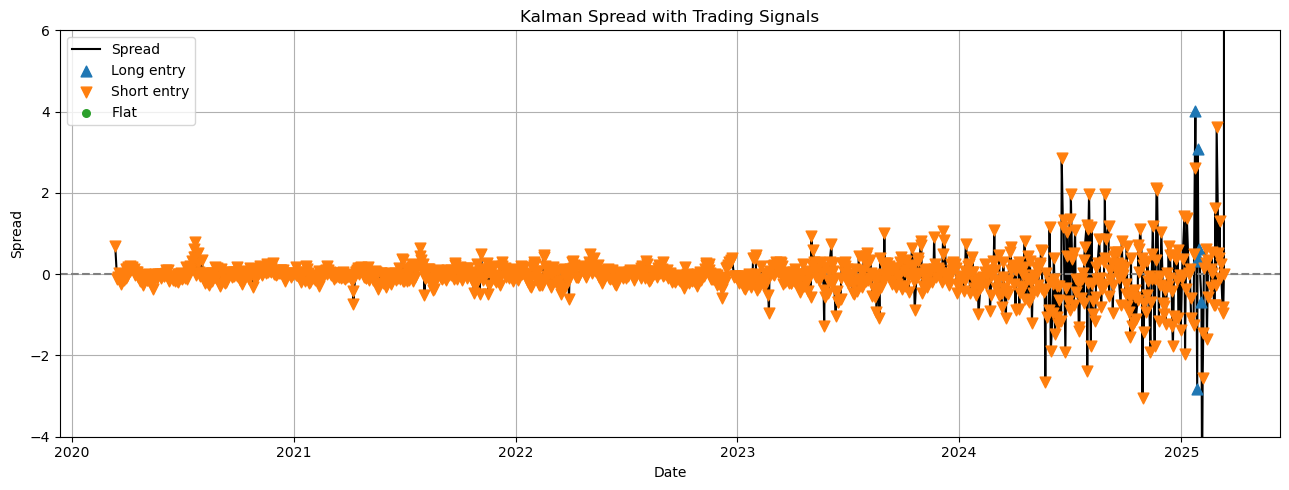

In [24]:
plt.figure(figsize=(13, 5))
plt.plot(df.index, df["spread_dyn"], color="black", label="Spread")
plt.ylim(-4,6)
plt.axhline(0, color="grey", ls="--")

plt.scatter(df.index[df["position"] ==  1],
            df["spread_dyn"][df["position"] ==  1],
            marker="^", s=60, label="Long entry", zorder=3)

plt.scatter(df.index[df["position"] == -1],
            df["spread_dyn"][df["position"] == -1],
            marker="v", s=60, label="Short entry", zorder=3)

plt.scatter(df.index[(df["position"] == 0) & (sig == 0)],
            df["spread_dyn"][(df["position"] == 0) & (sig == 0)],
            marker="o", s=30, label="Flat", zorder=3)

plt.title("Kalman Spread with Trading Signals")
plt.xlabel("Date");  plt.ylabel("Spread")
plt.grid();  plt.legend();  plt.tight_layout()
plt.show()


In [15]:
# 4.2. implementing Kalman Filter

# get numpy arrays for calculation
x = df['AMD'].values
y = df['NVDA'].values
n = len(x)

# intialise Kalman filter parameters
beta = np.zeros(n)
P = np.zeros(n)
Q = 0.001 # provess noise covariance
R = 1 # observing noise covariance

# the initial guesses
beta[0] = 0
P[0] = 1

# Kalman Filter Iteration
for t in range(1, n):
    # prediction
    # assuming hedge ratio follows random walk
    beta_pred = beta[t-1]
    P_pred = P[t-1] + Q
    # Update
    # K = Kalman Gain (how much weight to give the new obser vs predic)
    K = P_pred * x[t] / (x[t]**2 * P_pred + R)
    beta[t] = beta_pred + K * (y[t] - beta_pred * x[t])
    P[t] = (1 - K * x[t]) * P_pred

# computing dynamic spread
spread_kalman = y - beta * x

# ADF test on the dynamic spread
adf_result_kalman = adfuller(spread_kalman)
adf_stat_kalman = adf_result_kalman[0]
p_val_kalman = adf_result_kalman[1]

(adf_stat_kalman, p_val_kalman)


(-8.25083610828318, 5.396619062243376e-13)

In [16]:
# visualising Kalman Filter

# plot for the dynamic hedge ratio over time
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], beta, label='Dynamic Hedge Ratio (βₜ)', color='darkblue')
plt.title('Kalman Filter: Dynamic Hedge Ratio Over Time')
plt.xlabel('Date')
plt.ylabel('Hedge Ratio (βₜ)')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# plot for the Kalman spread
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], spread_kalman, label='Kalman Filter Spread', color='darkred')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Spread from Kalman Filter Hedge Ratio')
plt.xlabel('Date')
plt.ylabel('Spread (yₜ - βₜxₜ)')
# plt.xlim(0,2025)
plt.ylim(0,1)
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


KeyError: 'Date'

<Figure size 1200x500 with 0 Axes>

In [ ]:
# 4.3. calculating the spread

# using the dynamic hedge ratio
spread_kalman = y - beta * x
# first few values of the spread
spread_kalman[:5]


In [ ]:
# 5.implement trading strategy 

# 5.1. calculate z score of the spread 
mean_spread = np.mean(spread_kalman)
std_spread = np.std(spread_kalman)
# Z-score calculation
z_score = (spread_kalman - mean_spread) / std_spread

# 5.2. generating trading signals based on Z-score thresholds
# create zero signals first 
signals = np.zeros_like(z_score)

# trading logic and rules

# Long signal: Z < -1
signals[z_score < -1] = 1
# Short signal: Z > 1
signals[z_score > 1] = -1
# Exit signal: when Z moves back toward 0 (inside -0.5 to 0.5 range)
signals[np.abs(z_score) < 0.5] = 0

# first few signals
signals[:10]

In [ ]:
# visualising the trading rules 

# Create a signal-shifted position to simulate holding
positions = np.zeros_like(signals)
for t in range(1, len(signals)):
    if signals[t] != 0:
        positions[t] = signals[t]
    else:
        positions[t] = positions[t - 1]  # hold previous position

# Plot the spread and signals
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], spread_kalman, label='Kalman Spread', color='black')
plt.axhline(0, color='gray', linestyle='--')

# Mark long entries
plt.plot(df['Date'][signals == 1], spread_kalman[signals == 1], '^', markersize=8, color='green', label='Long Entry')
# Mark short entries
plt.plot(df['Date'][signals == -1], spread_kalman[signals == -1], 'v', markersize=8, color='red', label='Short Entry')
# Mark exits
plt.plot(df['Date'][np.abs(z_score) < 0.5], spread_kalman[np.abs(z_score) < 0.5], 'o', markersize=4, color='blue', label='Exit')

plt.title('Kalman Filter Spread with Trading Signals')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.ylim(-2,2)
# plt.xlim(pd.to_datetime('2025-01-01'), pd.to_datetime('2025-03-01'))
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Simulate PnL (basic) ---
# Daily return from spread change * previous position
spread_returns = np.diff(spread_kalman)
pnl = positions[:-1] * (-spread_returns)  # Short = profit when spread falls

# Cumulative PnL
cumulative_pnl = np.cumsum(pnl)

# Plot cumulative PnL
plt.figure(figsize=(14, 5))
plt.plot(df['Date'][1:], cumulative_pnl, color='darkblue')
plt.title('Cumulative PnL from Kalman Filter Pairs Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# section 7, optimisisng the parameters

# define grid of Q, R, entry and exit thresholds
Q_values = [1e-4, 1e-3, 1e-2] # process noise 
R_values = [0.5, 1, 2] # observation noise 
entry_thresholds = [0.5, 1, 1.5] # when to open a trade based on Z-score
exit_thresholds = [0.25, 0.5, 0.75] # when to close a trade 

# stroing performance results
results = []

# Grid search over all combinations of parameters 
for Q, R, entry, exit in itertools.product(Q_values, R_values, entry_thresholds, exit_thresholds):
    # initialise the kalman filter state 
    beta = np.zeros(n) # hedge ratio 
    P = np.zeros(n) # uncertainty 
    beta[0] = 0
    P[0] = 1
    
    # update them for each day 
    for t in range(1, n):
        beta_pred = beta[t - 1]
        P_pred = P[t - 1] + Q
        K = P_pred * x[t] / (x[t]**2 * P_pred + R)
        beta[t] = beta_pred + K * (y[t] - beta_pred * x[t])
        P[t] = (1 - K * x[t]) * P_pred

    # calculating spread b/w assets with beta 
    spread_kf = y - beta * x
    # converting the spread to z score 
    z_score = (spread_kf - np.mean(spread_kf)) / np.std(spread_kf)

    # generate trading signals 
    signals = np.zeros_like(z_score)
    signals[z_score < -entry] = 1 # go long 
    signals[z_score > entry] = -1 # go short 
    signals[np.abs(z_score) < exit] = 0 # exit

    # simulates holding positions over time
    positions = np.zeros_like(signals)
    for t in range(1, len(signals)):
        if signals[t] != 0:
            positions[t] = signals[t]
        else:
            # hold old position 
            positions[t] = positions[t - 1] 
    # calculate the profit 
    spread_returns = np.diff(spread_kf)
    pnl = positions[:-1] * (-spread_returns)
    cumulative_pnl = np.cumsum(pnl)

    results.append({
        'Q': Q,
        'R': R,
        'entry': entry,
        'exit': exit,
        'final_pnl': cumulative_pnl[-1]
    })

# Convert results to DataFrame and sort by final PnL
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='final_pnl', ascending=False)
tools.display_dataframe_to_user(name="Grid Search Kalman Parameters", dataframe=results_df)
